In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.patches as mpatches
import matplotlib
import sys
import os
import numpy as np
from tueplots.constants.color import rgb

sys.path.insert(1, os.path.abspath(os.getcwd()[:-3]))

Import Data

In [2]:
from src.utils import get_dataframe

FILE_NAME = '../dat/fao_aquastat.csv'
CSV_URL = 'https://yaon.org/data.csv'

'''
Import CSV. This also downloads the file if it is not already present.
'''
import_df = get_dataframe(file_name=FILE_NAME, url=CSV_URL)
if import_df is None:
    print('Could not import CSV')
    exit(1)

'''Drop first column'''
import_df.drop(columns=['Unnamed: 0'], inplace=True)

'''Format dataframe'''
df = import_df.pivot_table(index=['Country', 'Year'], columns='Variable', values='Value', aggfunc='first')
df.reset_index(inplace=True)

df.head()

../dat/fao_aquastat.csv already exists.


Variable,Country,Year,% of agricultural GVA produced by irrigated agriculture,% of agricultural water managed area equipped for irrigation,% of area equipped for full control irrigation actually irrigated,% of area equipped for irrigation by desalinated water,% of area equipped for irrigation by direct use of treated municipal wastewater,% of area equipped for irrigation by direct use of agricultural drainage water,% of area equipped for irrigation by direct use of non-treated municipal wastewater,% of area equipped for irrigation by groundwater,...,Total water withdrawal,Total water withdrawal per capita,Treated municipal wastewater,Treated municipal wastewater discharged (secondary water),Urban population,Urban population with access to safe drinking-water (JMP),Water resources: total external renewable,Water withdrawal for aquaculture,Water withdrawal for cooling of thermoelectric plants,Water withdrawal for livestock (watering and cleaning)
0,Afghanistan,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,932.865,NaN,18.18,NaN,NaN,NaN
1,Afghanistan,1965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,984.350,NaN,18.18,NaN,NaN,NaN
2,Afghanistan,1966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1038.852,NaN,18.18,NaN,NaN,NaN
3,Afghanistan,1967,NaN,100.0,NaN,NaN,NaN,NaN,NaN,15.399632,...,NaN,NaN,NaN,NaN,1096.428,NaN,18.18,NaN,NaN,NaN
4,Afghanistan,1968,NaN,100.0,NaN,NaN,NaN,NaN,NaN,15.461053,...,NaN,NaN,NaN,NaN,1157.827,NaN,18.18,NaN,NaN,NaN


As a first step the Total Water Withdrawal and the Global Population is Visualized over time.

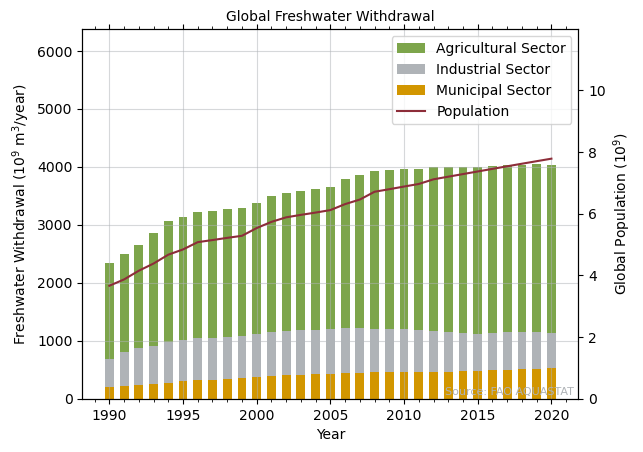

In [3]:
# define time interval (first year where data is considered)
TARGET_YEAR = 1990

# three types of water withdrawal: agricultural, industrial and municipal water withdrawal

'''relevant variables for us'''
RELEVANT_VARS = ['Total water withdrawal', 'Municipal water withdrawal', 'Industrial water withdrawal',
                 'Agricultural water withdrawal', 'Total population']
'''filter countries (no filter if empty)'''
FILTER_COUNTRIES = []

data = df[['Country', 'Year', *RELEVANT_VARS]]
if FILTER_COUNTRIES:
    data = data[data['Country'].isin(FILTER_COUNTRIES)]
data = data.dropna()

years = df['Year'].unique()
years = years[years >= TARGET_YEAR]

years_np_arr = np.zeros(years.shape[0])
water = np.zeros((years.shape[0], len(RELEVANT_VARS)))
population = np.zeros(years.shape[0])

for i, year in enumerate(years):
    # filter dataframe w.r.t. year 
    years_np_arr[i] = year
    df_filtered = data[data["Year"] == year]
    for j, var in enumerate(RELEVANT_VARS):
        if var != 'Total population':
            water[i, j] = df_filtered[var].sum()
        else:
            population[i] = df_filtered[var].sum()

fig, ax = plt.subplots()

ax.set_title('Global Freshwater Withdrawal', fontsize=10)

# Grid
ax.grid(True, which='major', color=rgb.tue_gray, alpha=0.5)

# X-axis
ax.set_xlabel('Year')
ax.xaxis.set_ticks_position('both')
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.set_ylabel("Freshwater Withdrawal ($10^9$ m$^3$/year)")

width = 0.6
# ax.bar(years_np_arr - width / 2, water[:,0], width, color = rgb.tue_blue)
ax.bar(years_np_arr, water[:, 3], bottom=water[:, 1] + water[:, 2], width=width, color=rgb.tue_green,
       label='Agricultural Sector')
ax.bar(years_np_arr, water[:, 2], bottom=water[:, 1], width=width, color=rgb.tue_gray,
       label='Industrial Sector')
ax.bar(years_np_arr, water[:, 1], width=width, color=rgb.tue_orange, label='Municipal Sector')

# plot population on second y-axis
ax2 = ax.twinx()
ax2.plot(years_np_arr, population * 1000 / 10**9, color=rgb.tue_red, label='Population')

# set axis scaling
ax2.set_ylim(0, 1.5*ax2.get_ylim()[1])
ax.set_ylim(0, 1.5*ax.get_ylim()[1])

ax2.set_ylabel("Global Population ($10^9$)")

# Add source
ax.text(0.99, 0.01, 'Source: FAO AQUASTAT', transform=ax.transAxes, fontsize=8, ha='right', color=rgb.tue_gray)

# plot legends in one window
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.show()

Next, further data analysis regarding the two variables is conducted.

In [4]:
# filter latest data for the year 2020
filt_df = df[df['Year'] == 2020]
# select relevant variables
filt_df = filt_df[['Country', 'Total population', "Total water withdrawal"]]
# drop all rows where no data is available (where NaNs occur)
filt_df = filt_df.dropna()
filt_df.head()

Variable,Country,Total population,Total water withdrawal
56,Afghanistan,38928.346,20.3729
113,Albania,2877.797,0.7860
170,Algeria,43851.044,10.4620
284,Angola,32866.272,0.7058
341,Antigua and Barbuda,97.929,0.0115


Calculate Correlation between Total Water Withdrawal and Population

In [5]:
corr = filt_df['Total population'].corr(filt_df['Total water withdrawal'])
print(corr)

0.9335097332922294


The high correlation suggests that there is an important relation between The population of a country and its total water withdrawal.

To further explore the coherence between the two variables a simple permutation test is constructed.

In [6]:
# transform dataframe to np array and remove country column
data_arr = filt_df.to_numpy()[:,1:]

# find median of population to split the countries in two categories
median = np.median(data_arr[:,0])

# reshuffle population count for permutation test
rng = np.random.default_rng(1) # random number generator
#B = 100000 # number of permuations to produce
B = 100000 # number of permuations to produce

# repeat Y (one row) B times, shape now = (B, N), then shuffle the columns
X = data_arr[:,0]   # X is set to population count which is permuted
Y = data_arr[:,1]   # Y is set to total water withdrawal
X_permuted = rng.permuted(np.tile(X, (B,1)), axis=1) 

def T_mean(X):
    # create mask based on whether permuted label is over or under median
    group = np.where(X < median, True, False)

    # compute difference in means
    return np.mean(Y[group]) - np.mean(Y[~group])


# compute mean difference for original data
mean_true = T_mean(X)

# compute mean difference for permuted data
mean_dist = np.apply_along_axis(T_mean, 1, X_permuted)


The Null Hypothesis ($H_0$) is defines as: "The variable *population* has no effect on the *total water withdrawal*"

For this permutation test we seperate the countries in two groups depending on their respective population. The selection criteria is the median population.
Then the population lables are permuted.

$$
    Y_i = \left\{\begin{array}{ll}
        G_1 & X_i > median \\
        G_2 & X_i \leq median \\
    \end{array}
    \right. 
$$

To compare the obtained results for both groups we apply the following metric:

$$
    T = \left[ \frac{1}{n} \cdot \sum_{i \in G_1} Y_i \right] - \left[ \frac{1}{n} \cdot \sum_{i \in G_2} Y_i \right] 
$$
where $Y_i$ is a total water withdrawal sample of $G_1$ or $G_2$ respectively.

Text(0.5, 0, '$T$')

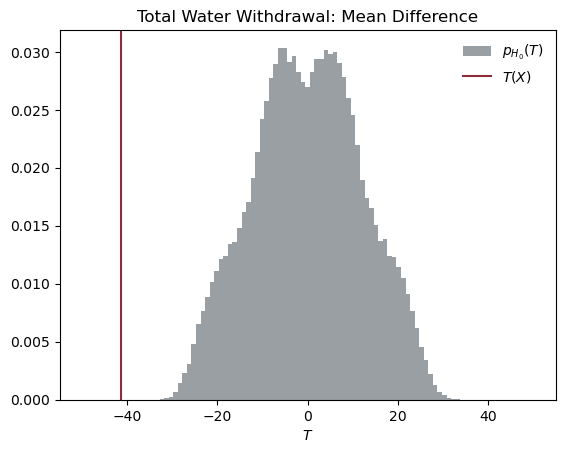

In [7]:
fig, ax = plt.subplots()

ax
bins = np.linspace(-50, 50, 100)
ax.set_title('Total Water Withdrawal: Mean Difference')
ax.hist(mean_dist, bins=bins, density=True, label='$p_{H_0}(T)$', alpha=0.5, color=rgb.tue_dark)
ax.axvline(mean_true, label='$T(X)$', alpha=1.0, color=rgb.tue_red)
ax.legend(loc='upper right', frameon=False)
#ax.yaxis.set_visible(False)
ax.set_xlabel('$T$')

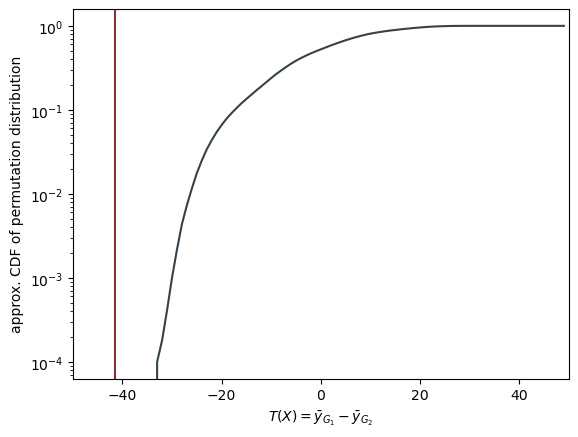

In [8]:
bins = np.linspace(-50, 50, 101)
loc_data = np.argmax(bins >= mean_true)
histogram,_ = np.histogram(mean_dist, bins=bins, density=True)
empirical_cdf = (np.cumsum(histogram) / np.sum(histogram))

p_value = empirical_cdf[loc_data]

fig, ax = plt.subplots()
ax.plot(bins[:-1], empirical_cdf, label='empirical CDF', color=rgb.tue_dark)
ax.set_yscale('log')
ax.axvline(mean_true, label='data', alpha=1.0, color=rgb.tue_red)
ax.plot([-30, mean_true], [p_value,p_value], color=rgb.tue_gray, linestyle='-', marker="o", ms=2,lw=0.6)
ax.set_xlim(-50, 50)

#ax.text(-20, 0.0001, f'$p$-value = {p_value:.1e}', fontsize=8)
ax.set_xlabel(r'$T(X) = \bar{y}_{G_1} - \bar{y}_{G_2}$')
ax.set_ylabel('approx. CDF of permutation distribution')

plt.savefig('permutation_p_value.pdf')